In [1]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ensure plots are shown inline
%matplotlib inline

In [3]:
scores_csv = "scores.csv"
df = pd.read_csv(scores_csv)
print(df.columns.values.tolist())

['Essay ID', 'Correction Style', 'System', 'GLEU', 'Precision', 'Recall', 'F0.5', 'Scribendi Score']


In [4]:
def extract_unique_values(df, column):
    return df[column].unique().tolist()

In [5]:
MINIMAL = "minimal"
FLUENCY = "fluency"
VIKING = "Viking-7B"
UAM_CSI = "UAM-CSI"
GLEU = "GLEU"
PRECISION = "Precision"
RECALL = "Recall"
F05 = "F0.5"
SCRIBENDI_SCORE = "Scribendi Score"
versions = [MINIMAL, FLUENCY]
teams = [VIKING, UAM_CSI]
metrics = [GLEU, PRECISION, RECALL, F05, SCRIBENDI_SCORE]
continuous_metrics = [GLEU, PRECISION, RECALL, F05]
ordinal_metrics = [SCRIBENDI_SCORE]

In [6]:
df = df.sort_values(by=["System", "Correction Style", "Essay ID"])

In [7]:
def extract_team_version_metric(team, version, metric):
    return df[(df["System"] == team) & (df["Correction Style"] == version)][
        metric
    ].to_numpy()


def extract_team_version(team, version):
    return {
        metric: extract_team_version_metric(team, version, metric) for metric in metrics
    }


def extract_team(team):
    return {version: extract_team_version(team, version) for version in versions}


values = {team: extract_team(team) for team in teams}

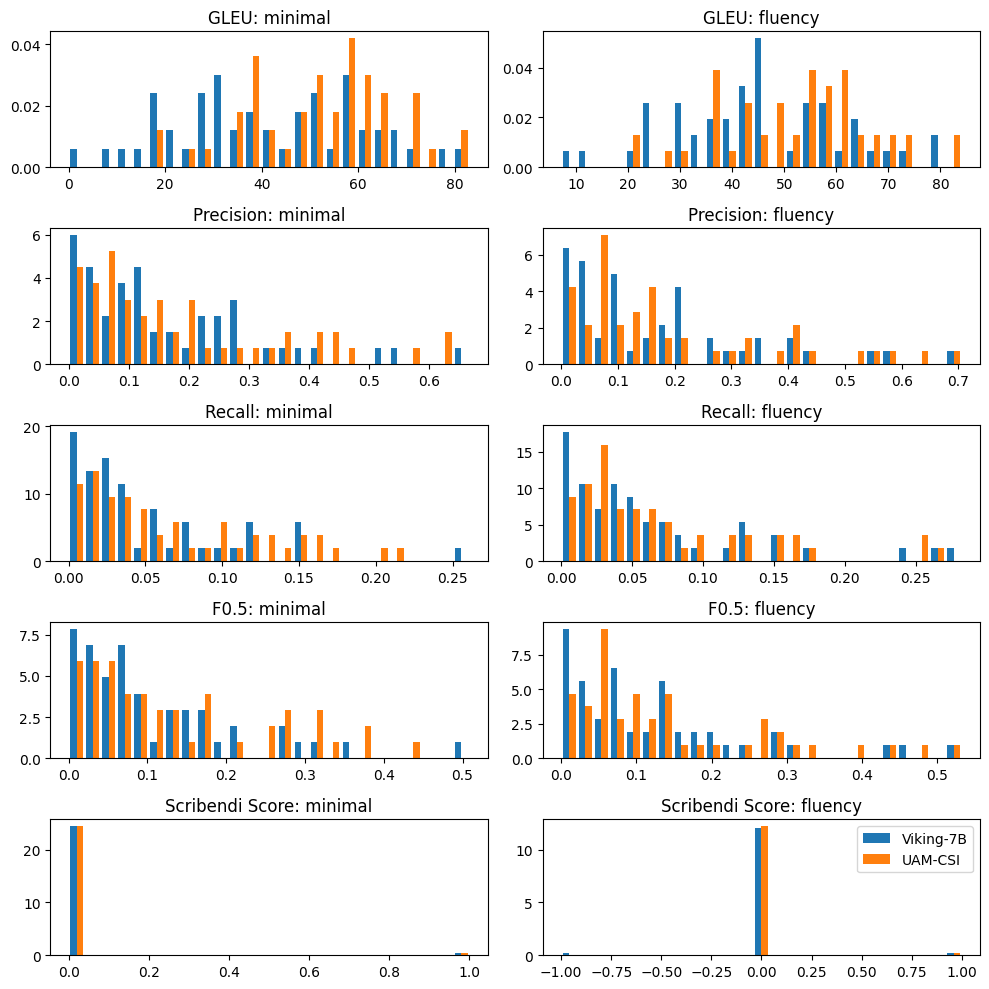

In [19]:
rows, cols = len(metrics), len(versions)
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 2 * len(metrics)))

num_bins = 25

colors = ["blue", "orange"]

for row, metric in enumerate(metrics):
    for col, version in enumerate(versions):
        plot_data = [values[team][version][metric] for team in teams]

        axs[row, col].hist(plot_data, num_bins, density=True, histtype="bar")
        axs[row, col].set_title(f"{metric}: {version}")

plt.legend([team for team in teams])

fig.tight_layout()
plt.show()

In [ ]:
alpha = 0.05


def perform_test(metric, version):
    viking_values = values[VIKING][version][metric]
    uamcsi_values = values[UAM_CSI][version][metric]
    if metric in continuous_metrics:
        return ttest_rel(viking_values, uamcsi_values)
    elif metric in ordinal_metrics:
        return wilcoxon(viking_values - uamcsi_values)
    else:
        raise ValueError(f"Unknown metric {metric}")


results = []
for metric in metrics:
    for version in versions:
        test_result = perform_test(metric, version)
        p_value = test_result.pvalue
        is_significant = p_value < alpha
        result_dict = {
            "metric": metric,
            "version": version,
            "p_value": p_value,
            "significant": is_significant,
        }
        results.append(result_dict)

In [ ]:
results_df = pd.DataFrame(results)

print(results_df)